#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

## Подготовка

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import fbeta_score, make_scorer
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 16, 6

import warnings
warnings.filterwarnings("ignore")

In [17]:
data = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<b>Вывод</b>

Даны заказы такси с интервалом 10 минут с 2018-03-01 00:00:00 по 2018-08-31 23:50:00, пропусков нет, стандартное отклонение 45.
Всего один признак: колличество заказов. Необходимо создать признаки календарные, скользящие и отстающие значения.

## Анализ

Проведем ресемплирование и отобразим граффик

<AxesSubplot:xlabel='datetime'>

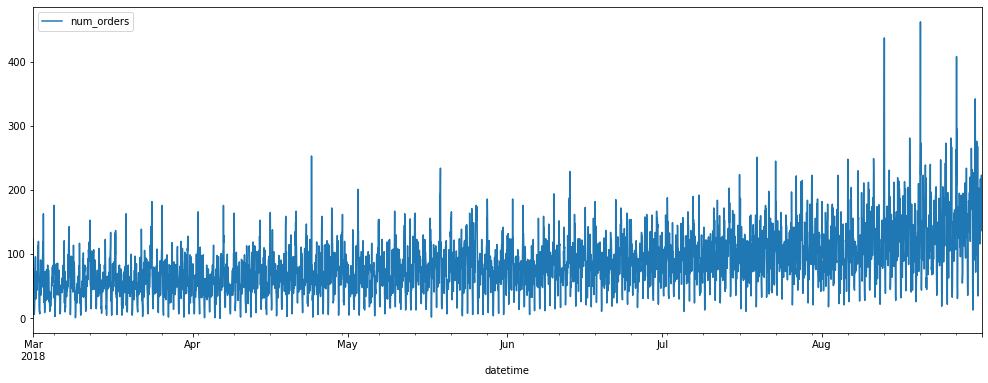

In [21]:
data = data.resample('1H').sum()
figsize = (17, 6)
data.plot(figsize=figsize)

Разложим временной ряд на три составляющие: тренд, сезонность и остаток

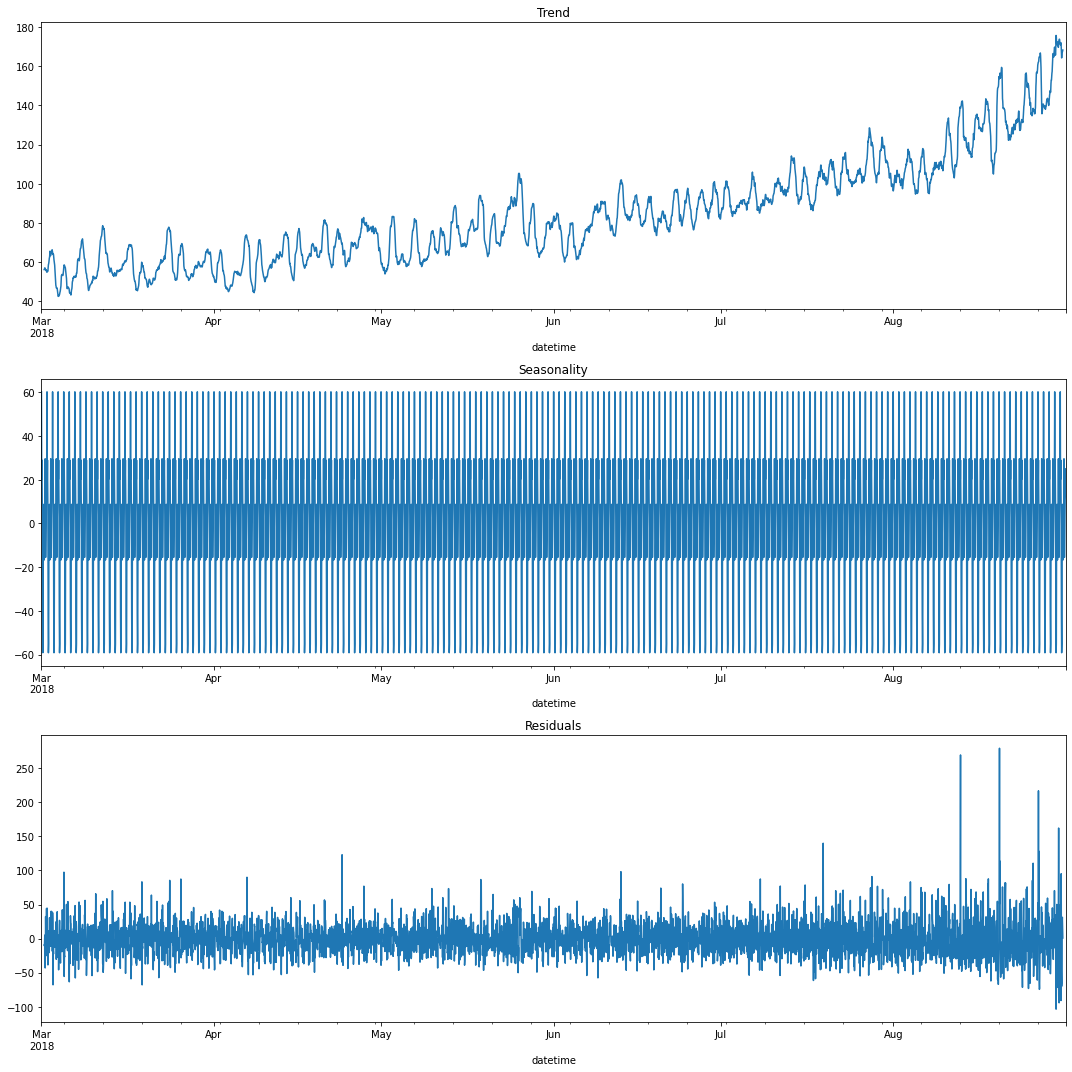

In [57]:
decomposed_data = seasonal_decompose(data)
plt.figure(figsize=(15, 15))
plt.subplot(311)
decomposed_data.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_data.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_data.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Разложим последнюю неделю на три составляющие: тренд, сезонность и остаток

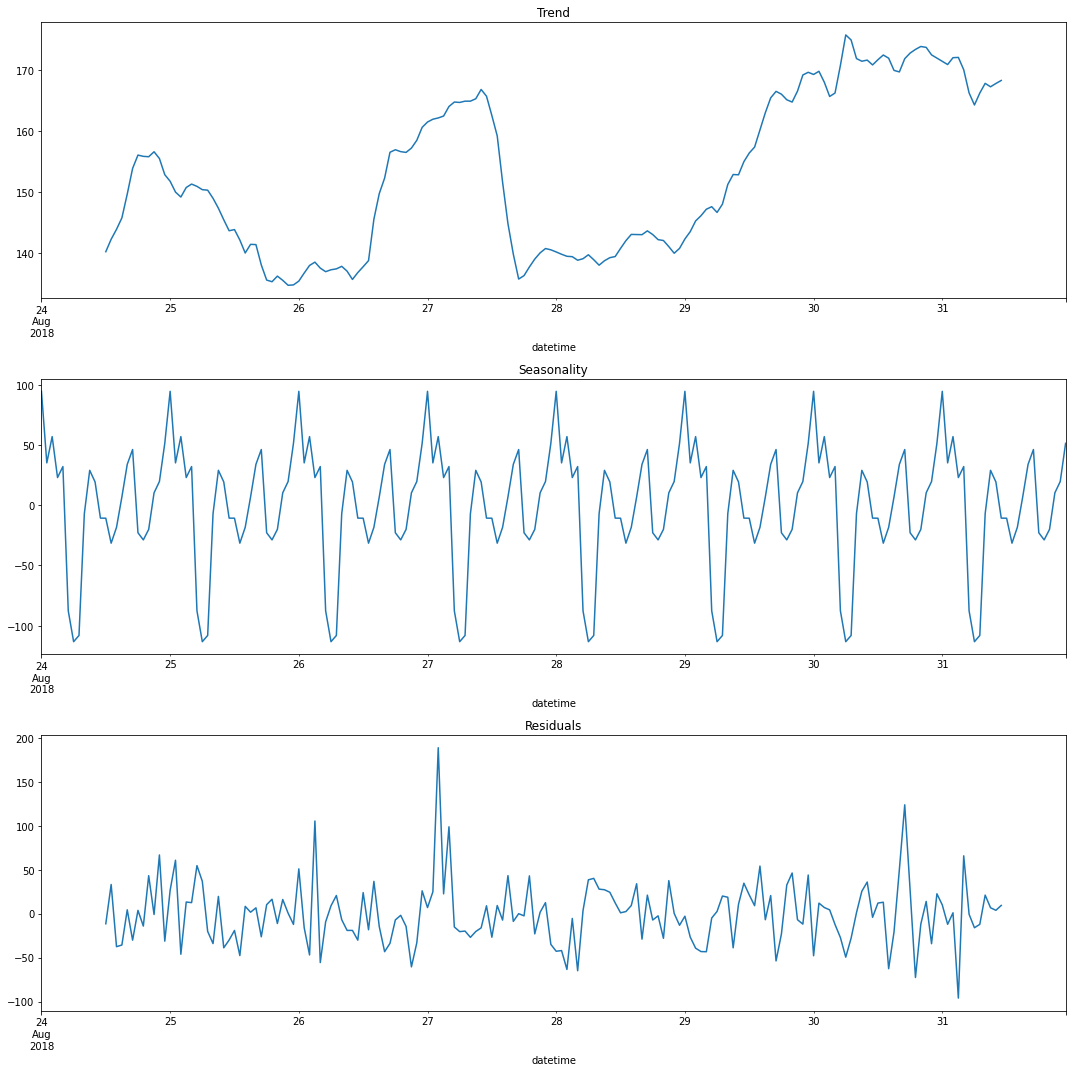

In [58]:
decomposed_data = seasonal_decompose(data['2018-08-24':'2018-08-31'])
plt.figure(figsize=(15, 15))
plt.subplot(311)
decomposed_data.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_data.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_data.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<b>Вывод</b>

- Дисперсия ряда всего датасета со временем увеличивается, временной ряд не является стационарным, так как подвержен тренду;
- по тренду видно, что со временем все больше и больше людей пользуется услугой заказа такси;
- спрос высокий в понедельник и увеличивается со среды по пятницу, выходные дни менее активны;
- при разложении по последней неделе видно, что имеются пиковые часы и больше всего такси используется в ночное время и дальше спрос максимально спадает под утро.


Создам функцию make_features которая:

Добавляет фактор месяца и фактор дня исходя из общего тренда

Добавляет фактор дня недели, так как на графике недели видим большую вариацию Добавляет фактор часа, так как прослеживаем 
пики активности в течении суток добавляет lag

Добавляет rolling просто переберу

In [1]:
def make_features(df, max_lag, rolling_sum_size):
    mf_df = data.copy(deep=True)
    mf_df['month'] = df.index.month
    mf_df['dayofweek'] = df.index.dayofweek
    mf_df['hour'] = df.index.hour
    for lag in range(1, max_lag + 1):
        mf_df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    mf_df['rolling_sum'] = df['num_orders'].shift().rolling(rolling_sum_size).mean()
    return mf_df

Создадим функцию для вычесления rmse

In [60]:
def rmse(first_list, second_list):
    return np.sqrt(mean_squared_error(first_list, second_list))

## Обучение

<b> Линейная регрессия </b>

<b>Фактор rolling</b>

In [74]:
best_rmse = 99999999
for log in range(47, 50):
    for rsz in range(2, 5):
        find_data = make_features(data, log, rsz)

        data_lr, test = train_test_split(find_data, shuffle=False, test_size=0.1)
        train, valid = train_test_split(data_lr, shuffle=False, test_size=0.25)
        train = train.dropna()
        features_train = train.drop("num_orders", axis=1)
        target_train = train["num_orders"]

        features_valid = valid.drop("num_orders", axis=1)
        target_valid = valid["num_orders"]

        lin_reg = LinearRegression()
        lin_reg.fit(features_train, target_train)

        preds = lin_reg.predict(features_valid)

        current_rmse = rmse(preds, target_valid)
        if current_rmse < best_rmse:
            best_rmse = current_rmse
            best_rsz = rsz
            best_log = log
print("RMSE:", best_rmse, "\nrolling_sum:", best_rsz, "\nlog:", best_log)

RMSE: 29.494524663526946 
rolling_sum: 3 
log: 48


In [75]:
data_lr = make_features(data, best_log, best_rsz) 

train, test = train_test_split(data_lr, shuffle=False, test_size=0.1)
train.dropna(inplace=True)
test.dropna(inplace=True)

features_train = train.drop("num_orders", axis=1)
target_train = train["num_orders"]

features_test = test.drop("num_orders", axis=1)
target_test = test["num_orders"]

In [72]:
target_train

datetime
2018-03-03 00:00:00    163
2018-03-03 01:00:00    108
2018-03-03 02:00:00     25
2018-03-03 03:00:00     64
2018-03-03 04:00:00     44
                      ... 
2018-08-13 09:00:00    137
2018-08-13 10:00:00    156
2018-08-13 11:00:00    144
2018-08-13 12:00:00     92
2018-08-13 13:00:00    119
Freq: H, Name: num_orders, Length: 3926, dtype: int64

<b> Cat Boost </b>

In [76]:
modelCat = CatBoostRegressor( random_state = 12345)
hyperparams = [{'depth' : [3], #брал 1, 2, 3
                'learning_rate' : [0.1], #брал 0.03, 0.06, 0.1
                'iterations' : [300], #брал 100, 200, 300
                'verbose' : [False]
               }]
my_cv=TimeSeriesSplit(n_splits=3).split(features_train)
clf = GridSearchCV(modelCat, hyperparams, cv=my_cv, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
best_params_CBR = clf.best_params_
print(best_params_CBR)
print((clf.best_score_*-1)**0.5)

{'depth': 3, 'iterations': 300, 'learning_rate': 0.1, 'verbose': False}
25.142273200135023


<b> LGBMRegressor </b>

In [77]:
LGBMR = LGBMRegressor() 
hyperparams = [{'depth' : [3],
                'learning_rate':[0.03],
                'verbose' : [10],
                'random_state':[12345]}]

my_cv=TimeSeriesSplit(n_splits=3).split(features_train)
clf = GridSearchCV(modelCat, hyperparams, cv=my_cv, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)

0:	learn: 28.8728318	total: 2.69ms	remaining: 2.69s
10:	learn: 25.8877599	total: 22.3ms	remaining: 2.01s
20:	learn: 23.7651463	total: 41.6ms	remaining: 1.94s
30:	learn: 22.2099116	total: 59.7ms	remaining: 1.86s
40:	learn: 21.0153473	total: 76.9ms	remaining: 1.8s
50:	learn: 20.1580958	total: 94.4ms	remaining: 1.76s
60:	learn: 19.5652529	total: 112ms	remaining: 1.72s
70:	learn: 19.0885712	total: 129ms	remaining: 1.69s
80:	learn: 18.6982266	total: 146ms	remaining: 1.66s
90:	learn: 18.3558115	total: 164ms	remaining: 1.64s
100:	learn: 18.0814573	total: 182ms	remaining: 1.62s
110:	learn: 17.8481231	total: 201ms	remaining: 1.61s
120:	learn: 17.6426680	total: 218ms	remaining: 1.59s
130:	learn: 17.4706431	total: 237ms	remaining: 1.57s
140:	learn: 17.2929597	total: 256ms	remaining: 1.56s
150:	learn: 17.1336637	total: 280ms	remaining: 1.57s
160:	learn: 17.0111606	total: 298ms	remaining: 1.55s
170:	learn: 16.8642976	total: 316ms	remaining: 1.53s
180:	learn: 16.7447616	total: 333ms	remaining: 1.51s

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f6228ab0f20>,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f624735e0a0>,
             param_grid=[{'depth': [3], 'learning_rate': [0.03],
                          'random_state': [12345], 'verbose': [10]}],
             scoring='neg_mean_squared_error')

In [78]:
print(clf.best_params_)
print((clf.best_score_*-1)**0.5)

{'depth': 3, 'learning_rate': 0.03, 'random_state': 12345, 'verbose': 10}
25.201980051746094


## Тестирование

<b> Линейная регрессия </b>

43.15116559232517


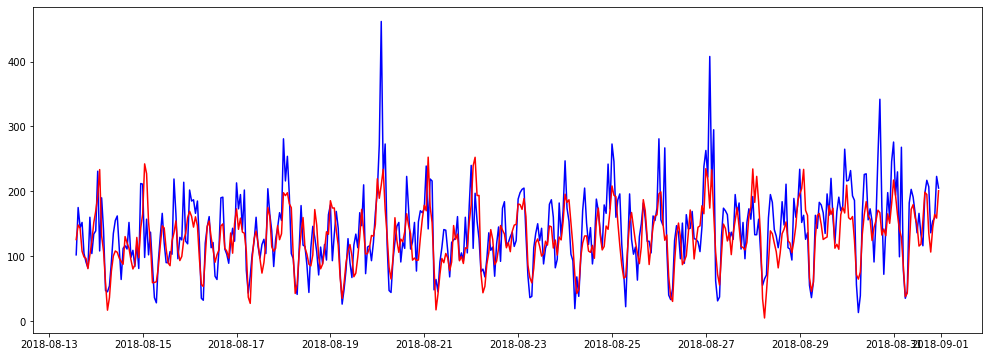

In [79]:
model = LinearRegression()
model.fit(features_train, target_train)
target_predict = model.predict(features_test)
rmse_lr = mean_squared_error(target_test, target_predict) ** 0.5
print(rmse_lr)
plt.figure(figsize=figsize)
plt.plot(target_test.index, target_test, 'b-', target_test.index, target_predict,'r-')

<b> Cat Boost </b>

40.05884576139077


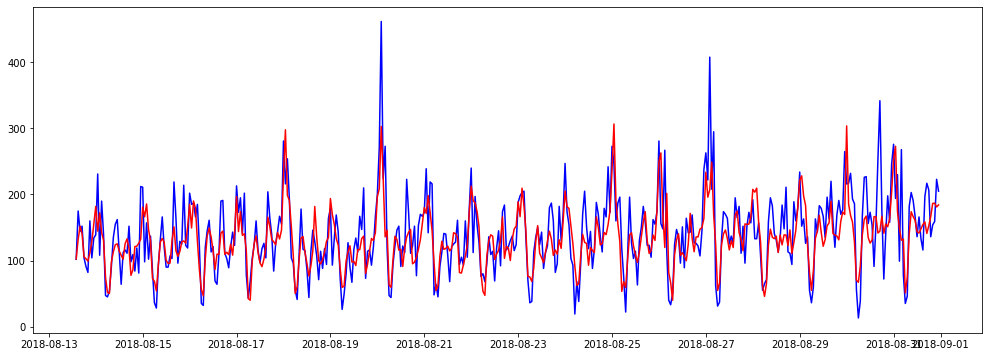

In [80]:
modelCat = CatBoostRegressor(depth = 3, iterations = 300, learning_rate = 0.1, verbose= False)
modelCat.fit(features_train, target_train)
modelCat_predict = modelCat.predict(features_test)
rmse_cbr = mean_squared_error(target_test, modelCat_predict) ** 0.5
print(rmse_cbr)
plt.figure(figsize=figsize)
plt.plot(target_test.index, target_test, 'b-', target_test.index, modelCat_predict,'r-')

<b> LGBMRegressor </b>

[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.003739
[LightGBM] [Debug] init for col-wise cost 0.000007 seconds, init for row-wise cost 0.000900 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9411
[LightGBM] [Info] Number of data points in the train set: 3926, number of used features: 53
[LightGBM] [Info] Start training from score 78.516811
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth 

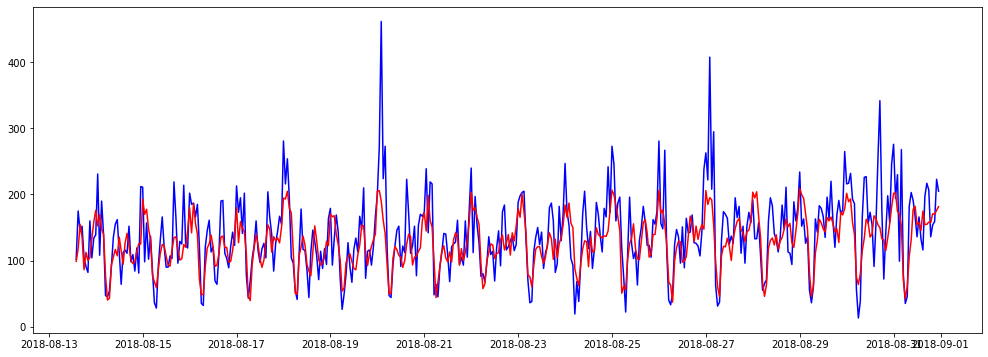

In [84]:
LGBMR = LGBMRegressor(depth = 3, learning_rate = 0.03, random_state = 12345, verbose = 10)
LGBMR.fit(features_train, target_train)
target_predict = LGBMR.predict(features_test)
rmse_LGBMR = mean_squared_error(target_test, target_predict) ** 0.5
print(rmse_LGBMR)
plt.figure(figsize=figsize)
plt.plot(target_test.index, target_test, 'b-', target_test.index, target_predict,'r-')

<b>Вывод</b>

По итогам тестирования лучше всего предсказала ряд модель Cat Boost. RMSE = 40.05. Ошибка на 40 заказов в час.

Далее идет LGBMRegressor = 41.87

Линейное тестирование 43.15

Можно предполжить, что большое количество шумов смогло негативно повлиять на регрессоры.